# Fully connected Neural Network approach to our data

In [1]:
import numpy as np
import torch

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
import os
import pandas as pd
import pickle

In [4]:
from sklearn.preprocessing import OneHotEncoder

## Load the preprocessed data

In [5]:
X_train = torch.load("../gds_as_flat_series/X_train_ts.pt")
X_test = torch.load("../gds_as_flat_series/X_test_ts.pt")
y_train = torch.load("../gds_as_flat_series/y_train_ts.pt")
y_test = torch.load("../gds_as_flat_series/y_test_ts.pt")

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([3840, 128])
torch.Size([960, 128])
torch.Size([3840, 16])
torch.Size([960, 16])


In [7]:
class GestureDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [8]:
training = GestureDataset(X_train, y_train)

# data loader
from torch.utils.data import DataLoader
train_loader = DataLoader(training, batch_size=32, shuffle=True)

C:\Users\masly\AppData\Local\Temp/ipykernel_6372/4022986565.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)
C:\Users\masly\AppData\Local\Temp/ipykernel_6372/4022986565.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [9]:
with open("../gds_as_flat_series/oh_encoder", "rb") as f:
    oh_encoder = pickle.load(f)

## Define the Net

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 100)
        self.fc2 = nn.Linear(100, 75)
        self.fc4 = nn.Linear(75, 45)
        self.fc5 = nn.Linear(45, num_classes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        output = F.log_softmax(self.fc5(x), dim=1)
        return output

Net(
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=75, bias=True)
  (fc4): Linear(in_features=75, out_features=45, bias=True)
  (fc5): Linear(in_features=45, out_features=16, bias=True)
)


In [51]:
net = Net(num_features=X_train.shape[1], num_classes=y_train.shape[1])
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
epochs = 200

Net(
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=75, bias=True)
  (fc4): Linear(in_features=75, out_features=45, bias=True)
  (fc5): Linear(in_features=45, out_features=16, bias=True)
)


In [52]:
train_loss, test_loss = {}, {}
train_accuracy, test_accuracy = {}, {}

for e in range(epochs):

    # Train epoch
    net.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        wanted = torch.max(labels, 1)[1]
        loss = criterion(outputs, wanted)
        loss.backward()
        optimizer.step()

    # Evaluate
    net.eval()
    with torch.no_grad():
        outputs = net(X_test)
        wanted = torch.max(y_test, 1)[1]
        loss = criterion(outputs, wanted)

        test_loss[e] = loss.item()
        test_accuracy[e] = outputs.argmax(dim=1).eq(wanted).sum().item() / wanted.shape[0]
        
        
        outputs = net(X_train)
        wanted = torch.max(y_train, 1)[1]
        loss = criterion(outputs, wanted)
        
        train_loss[e] = loss.item()
        train_accuracy[e] = outputs.argmax(dim=1).eq(wanted).sum().item() / wanted.shape[0]

    if e % 10 == 0:
        print(
            f"Epoch [{e}/{epochs}], Step [{i}/{len(train_loader)}], Loss: {float(loss.item()):1.6f}")


Epoch [0/200], Step [119/120], Loss: 2.676612
Epoch [10/200], Step [119/120], Loss: 0.142208
Epoch [20/200], Step [119/120], Loss: 0.040791
Epoch [30/200], Step [119/120], Loss: 0.047954
Epoch [40/200], Step [119/120], Loss: 0.008830
Epoch [50/200], Step [119/120], Loss: 0.006014
Epoch [60/200], Step [119/120], Loss: 0.005786
Epoch [70/200], Step [119/120], Loss: 0.028180
Epoch [80/200], Step [119/120], Loss: 0.004726
Epoch [90/200], Step [119/120], Loss: 0.003418
Epoch [100/200], Step [119/120], Loss: 0.003990
Epoch [110/200], Step [119/120], Loss: 0.003965
Epoch [120/200], Step [119/120], Loss: 0.004821
Epoch [130/200], Step [119/120], Loss: 0.004634
Epoch [140/200], Step [119/120], Loss: 0.002302
Epoch [150/200], Step [119/120], Loss: 0.005414
Epoch [160/200], Step [119/120], Loss: 0.003643
Epoch [170/200], Step [119/120], Loss: 0.002135
Epoch [180/200], Step [119/120], Loss: 0.003094
Epoch [190/200], Step [119/120], Loss: 0.002170


In [53]:
test_pred = net(X_test)
# print(test_pred.shape)

correct_count = test_pred.argmax(dim=1).eq(torch.max(y_test, 1)[1]).sum().item()
print(f"Testing accuracy: {float(correct_count / len(y_test)):1.4}")

Testing accuracy: 0.9938


In [57]:
def plot_all_losses(train_l=None, test_l=None, train_ac=None, test_ac=None, title=None):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), dpi=100)
    
    if title:
        fig.suptitle(title)
    if train_l:
        axes[0][0].plot(train_l)
        axes[0][0].set_title("Training Loss")
    if test_l:
        axes[0][1].plot(test_l)
        axes[0][1].set_title("Test Loss")
    if train_ac:
        axes[1][0].plot(train_ac)
        axes[1][0].set_title("Training Accuracy")
    if test_ac:
        axes[1][1].plot(test_ac)
        axes[1][1].set_title("Test Accuracy")

    plt.tight_layout()


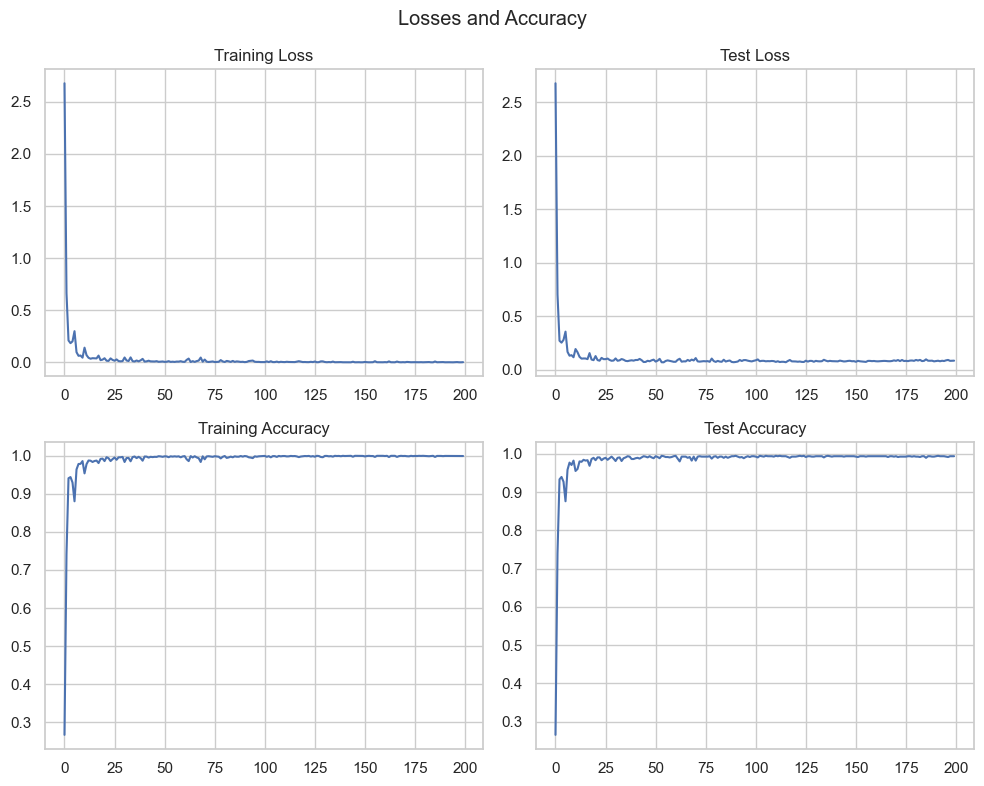

In [58]:
train_losses = list(train_loss.values())
train_accuracies = list(train_accuracy.values())
test_losses = list(test_loss.values())
test_accuracies = list(test_accuracy.values())

plot_all_losses(train_losses, test_losses, train_accuracies, test_accuracies, "Losses and Accuracy")